In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer




In [2]:
!pip install gensim

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#loading sample data on 10k values
con = sqlite3.connect('./sample10k.sqlite') 
sample = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
print (sample.head(3))
print (sample.shape)

   level_0   index      Id   ProductId          UserId  \
0    81587  337543  365220  B000HALT7Q  A2BB0XD2Z9RN20   
1   170719   94867  103101  B001E5E2RM  A2XSW93YS6YCVR   
2   349815  249863  270925  B006FKMB1K  A1Y4BC19C3PZ41   

              ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0  L. J. Baltes "NY Jeff"                     1                       1   
1                 Abigail                     0                       0   
2     S. Brown "Caliopia"                     1                       1   

      Score        Time                          Summary  \
0  positive  1179792000                   Super Solution   
1  positive  1311724800  I Love Torani sugar-free syrup!   
2  positive  1334102400                    Great Variety   

                                                Text  \
0  My indoor shorthair had severe hairball proble...   
1  I really like Torani Hazelnut sugar-free syrup...   
2  I bought this for my mother who just purchased...   



In [4]:

# sorting data by time
sample = sample.sort_values(by = 'Time')
sample.head(3)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
9209,3311,197136,213676,B0000D9MXU,A3MXE8CDJX12V2,"L. M. Schulz ""domestic engineer""",3,3,positive,1067644800,A Cheese the Whole Family Likes...,The description of a cross between cheddar and...,descript cross cheddar parmesan complet accur ...
5514,4696,292866,317257,B0000DIYUK,A2ZM9BGE3K3SY2,Sara Swihart,0,0,positive,1069286400,Tasty,"I like this flavor, but it kind of reminds me ...",like flavor kind remind jello pud bite thing n...
1728,4706,454840,491748,B0000DIYW9,A2ZM9BGE3K3SY2,Sara Swihart,0,0,positive,1069286400,Mmm...,This one is nice. I like using it in the 'reci...,one nice like use recip root beer float bad ca...


In [5]:
sample['Score'] = sample.Score.astype('category')
sample['Score'] = sample.Score.cat.codes
sample.head(3)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
9209,3311,197136,213676,B0000D9MXU,A3MXE8CDJX12V2,"L. M. Schulz ""domestic engineer""",3,3,1,1067644800,A Cheese the Whole Family Likes...,The description of a cross between cheddar and...,descript cross cheddar parmesan complet accur ...
5514,4696,292866,317257,B0000DIYUK,A2ZM9BGE3K3SY2,Sara Swihart,0,0,1,1069286400,Tasty,"I like this flavor, but it kind of reminds me ...",like flavor kind remind jello pud bite thing n...
1728,4706,454840,491748,B0000DIYW9,A2ZM9BGE3K3SY2,Sara Swihart,0,0,1,1069286400,Mmm...,This one is nice. I like using it in the 'reci...,one nice like use recip root beer float bad ca...


In [6]:
#seperating labels from final_sample
label = sample.Score
print (label.value_counts())
print (label.head(3))

1    8434
0    1566
Name: Score, dtype: int64
9209    1
5514    1
1728    1
Name: Score, dtype: int8


In [7]:
# train,cv, test split(60:20:20)
X_train = sample.CleanedText[:int(len(sample)*0.6)]
y_train = label[:int(len(sample)*0.6)]

X_cv = sample.CleanedText[int(len(sample)*0.6):int(len(sample)*0.8)]
y_cv = label[int(len(sample)*0.6):int(len(sample)*0.8)]

X_test = sample.CleanedText[int(len(sample)*0.8):]
y_test = label[int(len(sample)*0.8):]

print ('training set :', X_train.shape)
print ('cross-validation set:',X_cv.shape)
print('test set', X_test.shape)
print (X_train.head(2))
print (X_cv.head(2))
print (X_test.head(2))

training set : (6000,)
cross-validation set: (2000,)
test set (2000,)
9209    descript cross cheddar parmesan complet accur ...
5514    like flavor kind remind jello pud bite thing n...
Name: CleanedText, dtype: object
7844    can pumpkin kid one right mind would pay much ...
4645    there one thing cant handl rip beauti product ...
Name: CleanedText, dtype: object
3004    glad bought much easier pull clean big food pr...
5097    give paw origin flavor figur would like one we...
Name: CleanedText, dtype: object


# BOW vectorizer

In [8]:

# training data
count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_train.values)
print ('the type of count vectorizer' , type(X_train_bow))
print ('shape of text BOW vectorizer' , X_train_bow.get_shape())
print ('Number of unique words',X_train_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (6000, 10133)
Number of unique words 10133


In [9]:
# cross validation and test data
X_cv_bow = count_vec.transform(X_cv.values)
print ('the type of count vectorizer' , type(X_cv_bow))
print ('shape of text BOW vectorizer' , X_cv_bow.get_shape())
print ('Number of unique words',X_cv_bow.get_shape()[1])
print ('**********************************************************')
X_test_bow = count_vec.transform(X_test.values)
print ('the type of count vectorizer' , type(X_test_bow))
print ('shape of text BOW vectorizer' , X_test_bow.get_shape())
print ('Number of unique words',X_test_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (2000, 10133)
Number of unique words 10133
**********************************************************
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (2000, 10133)
Number of unique words 10133


In [10]:
# KNN brute

  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score


f1 = list()

n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i,algorithm='brute', n_jobs = -1)
    knn.fit(X_train_bow , y_train)
    pred = knn.predict(X_cv_bow)
    score = f1_score(y_cv, pred)
    f1.append(score)
    

print (f1)  

  
  
  
  

[0.8830945558739256, 0.89520624303233, 0.8978688070855245, 0.8993103448275862, 0.8999724441995041, 0.8994213281895838, 0.8992290748898679, 0.8995320671621251, 0.899284534947716, 0.8995320671621251, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705]


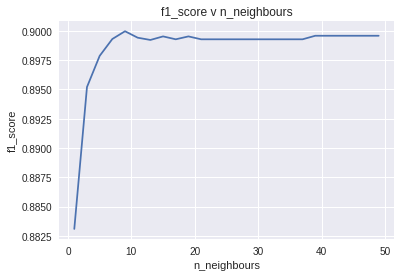

In [11]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [12]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )


number of neighbours : 9


In [13]:
# calculating model accuracy , f1_score on test data 
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors = 9 , algorithm='brute')
knn.fit(X_train_bow , y_train)
pred = knn.predict(X_test_bow)
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)


f1-score: 0.9092896174863389
accuracy: 0.834


In [14]:
# KNN with kdtree but we need to convert sparse matrix to dense using turncated SVD# BOW vectorizer
# training data
count_vec = CountVectorizer(max_features = 2000 , min_df = 50)
X_train_T = count_vec.fit_transform(X_train.values)
print ('the type of count vectorizer' , type(X_train_T))
print ('shape of text BOW vectorizer' , X_train_T.get_shape())
print ('Number of unique words',X_train_T.get_shape()[1])
X_train_T=X_train_T.toarray()


the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (6000, 738)
Number of unique words 738


In [15]:
# cross validation and test data
X_cv_T = count_vec.transform(X_cv.values)
print ('the type of count vectorizer' , type(X_cv_T))
print ('shape of text BOW vectorizer' , X_cv_T.get_shape())
print ('Number of unique words',X_cv_T.get_shape()[1])
X_cv_T = X_cv_T.toarray()
print ('**********************************************************')
X_test_T = count_vec.transform(X_test.values)
print ('the type of count vectorizer' , type(X_test_T))
print ('shape of text BOW vectorizer' , X_test_T.get_shape())
print ('Number of unique words',X_test_T.get_shape()[1])
X_test_T = X_test_T.toarray()

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (2000, 738)
Number of unique words 738
**********************************************************
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text BOW vectorizer (2000, 738)
Number of unique words 738


In [16]:
# finding optimal K using kd_tree algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='kd_tree')
    knn.fit(X_train_T , y_train)
    pred = knn.predict(X_cv_T)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1)  


[0.8592995169082126, 0.8808290155440415, 0.8900169204737732, 0.8969764837625981, 0.8972222222222221, 0.8991689750692521, 0.8986710963455149, 0.899696048632219, 0.8991434097817077, 0.8987586206896552, 0.8985107556536128, 0.8994213281895838, 0.8991735537190082, 0.8989815579410955, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716, 0.899284534947716]


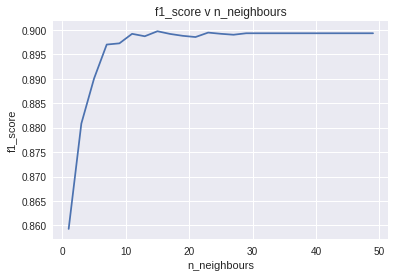

In [17]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [18]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 15


In [19]:
# calculating model accuracy , f1_score on test data 
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='kd_tree')
knn.fit(X_train_T , y_train)
pred = knn.predict(X_test_T)
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)


f1-score: 0.9104354971240756
accuracy: 0.8365


# TFIDF vectorizer

In [20]:
#tfidf sparse
tfidf_vect = TfidfVectorizer(ngram_range=(1,2)) #in scikit-learn
# training data
X_train_TS = tfidf_vect.fit_transform(X_train.values)
print ('the type of count vectorizer' , type(X_train_TS))
print ('shape of text tfidf vectorizer' , X_train_TS.get_shape())
print ('Number of unique words',X_train_TS.get_shape()[1])

# cross validation data
X_cv_TS = tfidf_vect.transform(X_cv.values)
print ('the type of count vectorizer' , type(X_cv_TS))
print ('shape of cv tfidf vectorizer' , X_cv_TS.get_shape())
print ('Number of unique words',X_cv_TS.get_shape()[1])

# test data
X_test_TS = tfidf_vect.transform(X_test.values)
print ('the type of count vectorizer' , type(X_test_TS))
print ('shape of text tfidf vectorizer' , X_test_TS.get_shape())
print ('Number of unique words',X_test_TS.get_shape()[1])


the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text tfidf vectorizer (6000, 151815)
Number of unique words 151815
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of cv tfidf vectorizer (2000, 151815)
Number of unique words 151815
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text tfidf vectorizer (2000, 151815)
Number of unique words 151815


In [21]:
# finding optimal K using 'brute' algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='brute')
    knn.fit(X_train_TS , y_train)
    pred = knn.predict(X_cv_TS)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1)  

[0.8656185108276476, 0.8948863636363635, 0.9041865692610285, 0.9058396200055882, 0.9041248606465999, 0.904284919309961, 0.9026696329254728, 0.9023307436182021, 0.9031900138696255, 0.903601108033241, 0.9038514824050985, 0.9024053082665192, 0.9024053082665192, 0.9021558872305141, 0.9016574585635361, 0.9019607843137255, 0.9017117614577582, 0.9017117614577582, 0.9015172413793103, 0.9017660044150111, 0.9019607843137255, 0.9020149047750484, 0.902317880794702, 0.9020149047750484, 0.9012686155543298]


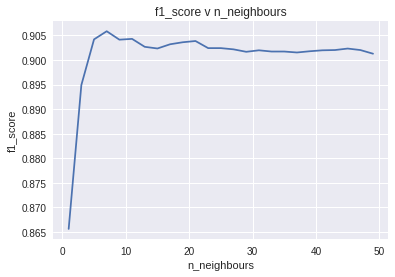

In [22]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [23]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 7


In [24]:
# calculating model accuracy , f1_score on test data 
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='brute')
knn.fit(X_train_TS , y_train)
pred = knn.predict(X_test_TS)
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)

f1-score: 0.9151414309484192
accuracy: 0.847


In [25]:
# TFIDF dense
# 
tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , max_features = 2000 , min_df = 50) #in scikit-learn
# training data
X_train_tfidf = tfidf_vect.fit_transform(X_train.values)
print ('the type of count vectorizer' , type(X_train_tfidf))
print ('shape of text tfidf vectorizer' , X_train_tfidf.get_shape())
print ('Number of unique words',X_train_tfidf.get_shape()[1])
X_train_tfidf = X_train_tfidf.toarray() 
# cross validation data
X_cv_tfidf = tfidf_vect.transform(X_cv.values)
print ('the type of count vectorizer' , type(X_cv_tfidf))
print ('shape of cv tfidf vectorizer' , X_cv_tfidf.get_shape())
print ('Number of unique words',X_cv_tfidf.get_shape()[1])
X_cv_tfidf = X_cv_tfidf.toarray() 
# test data
X_test_tfidf = tfidf_vect.transform(X_test.values)
print ('the type of count vectorizer' , type(X_test_tfidf))
print ('shape of text tfidf vectorizer' , X_test_tfidf.get_shape())
print ('Number of unique words',X_test_tfidf.get_shape()[1])
X_test_tfidf = X_test_tfidf.toarray() 

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text tfidf vectorizer (6000, 792)
Number of unique words 792
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of cv tfidf vectorizer (2000, 792)
Number of unique words 792
the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
shape of text tfidf vectorizer (2000, 792)
Number of unique words 792


In [26]:
# finding optimal K using 'kd-tree' algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='kd_tree')
    knn.fit(X_train_tfidf , y_train)
    pred = knn.predict(X_cv_tfidf)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1)  


[0.8659670164917541, 0.8965122927387077, 0.9063649222065063, 0.9069440539780713, 0.9054809843400446, 0.9044302033992757, 0.905849582172702, 0.9049471928849362, 0.9041932796445432, 0.9021889720144084, 0.9011354195513709, 0.9014941892639734, 0.9009407858328722, 0.9007464749792646, 0.9023513139695712, 0.9014084507042254, 0.9017117614577582, 0.9011595803423522, 0.9011595803423522, 0.9011595803423522, 0.9006622516556292, 0.9006622516556292, 0.9004137931034484, 0.9004687069203199, 0.900523560209424]


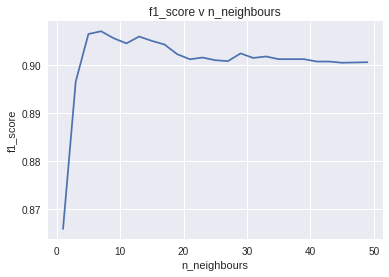

In [27]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [28]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 7


In [29]:
# calculating model accuracy , f1_score on test data 
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='kd_tree')
knn.fit(X_train_tfidf , y_train)
pred = knn.predict(X_test_tfidf)
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)

f1-score: 0.9143654114365412
accuracy: 0.8465


# W2V vectorizer

In [0]:
# w2v
# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
import gensim
i=0
list_of_sent_train=[]
for sent in X_train.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [0]:
# Doing the same for cv dataset.
list_of_sent_cv=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
  
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_cv.append(filtered_sentence)

In [0]:
# Doing the same for test dataset.
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
  
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [0]:
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

In [35]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3451
sample words  ['descript', 'cross', 'cheddar', 'parmesan', 'complet', 'accur', 'good', 'grate', 'top', 'hot', 'food', 'sandwich', 'slice', 'snack', 'yum', 'like', 'flavor', 'kind', 'remind', 'jello', 'pud', 'bite', 'thing', 'nasti', 'most', 'use', 'one', 'recip', 'creat', 'new', 'nice', 'root', 'beer', 'float', 'bad', 'cant', 'put', 'fizz', 'jelli', 'bean', 'red', 'rice', 'simpl', 'dish', 'everybodi', 'orlean', 'eat', 'kid', 'nativ', 'adopt']


In [36]:
#avgw2v 
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
      if word in w2v_words:
        vec = w2v_model.wv[word]
        sent_vec += vec
        cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
print (len(sent_vectors_train))
print (len(sent_vectors_train[0]))
print (sent_vectors_train[0])

6000
50
[-0.03081541 -0.16942528  0.37053947  0.3471693   0.06550465  0.00934745
 -0.26401369 -0.30525877 -0.03101374  0.05683156 -0.30106832  0.17902492
 -0.00511837  0.17858085  0.07908536  0.30436317 -0.75914407  0.43525635
  0.30143137  0.14100397  0.03731504  0.10614406 -0.68245442 -0.297536
 -0.11061337  0.0226358  -0.38545163  0.01072758 -0.2559826  -0.57147083
 -0.34911688  0.26625922  0.70745151 -0.41023391  0.09353385 -0.16736646
  0.33028037 -0.31072109  0.54585494 -0.25643198  0.32343879 -0.18092995
 -0.07295798  0.31890872  0.42281214 -0.2672844  -0.02893627 -0.00750387
  0.26162562  0.28167762]


In [37]:
#cv data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
      if word in w2v_words:
        vec = w2v_model.wv[word]
        sent_vec += vec
        cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print (len(sent_vectors_cv))
print (len(sent_vectors_cv[0]))
print (sent_vectors_cv[0])

2000
50
[-0.11506117  0.03697557  0.38389382  0.20394053  0.16599111  0.01921476
 -0.39480661 -0.19276667  0.03877799  0.19163031 -0.82590904  0.24100639
  0.05874299  0.50171781 -0.16481598  0.36166711 -0.53578268  0.45535518
  0.3487809  -0.08213433 -0.03801361 -0.22669842 -0.63709749 -0.23386939
  0.00416087  0.07147069 -0.66097269 -0.00295605 -0.33288088 -0.56098518
 -0.30418819  0.55681513  0.66098451 -0.18902001  0.09587804 -0.19500306
  0.19335874 -0.12522466  0.96838344 -0.18438177  0.25766709 -0.25785992
 -0.00221423  0.49825745  0.18847725 -0.37013166  0.15785538 -0.09851914
  0.1894895   0.33269256]


In [38]:
#test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
print (len(sent_vectors_test))
print (len(sent_vectors_test[0]))
print (sent_vectors_test[0])

2000
50
[-0.06241789 -0.080675    0.41396001  0.29841832  0.15331002  0.04628588
 -0.32013352 -0.20997566 -0.01493591  0.11570258 -0.59095525  0.14567367
  0.03995958  0.40593419 -0.00859472  0.33234925 -0.70057276  0.44520131
  0.30838994  0.00667427  0.00607884 -0.05636609 -0.65458139 -0.27453275
 -0.06115656  0.10285317 -0.57416795 -0.00457613 -0.33587821 -0.61892363
 -0.39616043  0.41613896  0.70232341 -0.31069726  0.07503797 -0.21832504
  0.2908604  -0.25319249  0.80080444 -0.27518648  0.29326626 -0.20831358
 -0.02951719  0.38664039  0.32444438 -0.32233076  0.06968842  0.01475471
  0.23433724  0.36840273]


In [39]:
# finding optimal K using 'brute' algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='brute')
    knn.fit(sent_vectors_train , y_train)
    pred = knn.predict(sent_vectors_cv)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1)  

[0.8362978595116068, 0.8734177215189874, 0.8848108413325804, 0.8926174496644296, 0.8964365256124721, 0.897642163661581, 0.8983097811027986, 0.897563676633444, 0.89908764169201, 0.9005524861878452, 0.8995030369961348, 0.8998067899530776, 0.9007717750826901, 0.9002754820936639, 0.9002754820936639, 0.9002754820936639, 0.9000275406224181, 0.8997797356828194, 0.8997797356828194, 0.9000825763831544, 0.8998348926802422, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705]


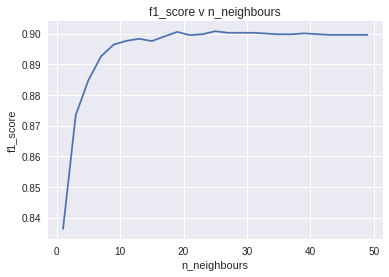

In [40]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [41]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 25


In [42]:
# calculating model accuracy , f1_score on test data
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='brute')
knn.fit(sent_vectors_train  , y_train)
pred = knn.predict(sent_vectors_test )
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)

f1-score: 0.9090412455613219
accuracy: 0.8335


In [43]:
# finding optimal K using 'kd_tree' algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='kd_tree')
    knn.fit(sent_vectors_train , y_train)
    pred = knn.predict(sent_vectors_cv)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

    
print (f1) 

[0.8362978595116068, 0.8734177215189874, 0.8848108413325804, 0.8926174496644296, 0.8964365256124721, 0.897642163661581, 0.8983097811027986, 0.897563676633444, 0.89908764169201, 0.9005524861878452, 0.8995030369961348, 0.8998067899530776, 0.9007717750826901, 0.9002754820936639, 0.9002754820936639, 0.9002754820936639, 0.9000275406224181, 0.8997797356828194, 0.8997797356828194, 0.9000825763831544, 0.8998348926802422, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705]


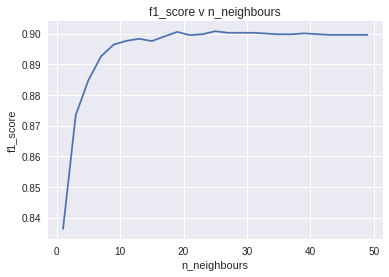

In [44]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [45]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 25


In [46]:
# calculating model accuracy , f1_score on test data 
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='kd_tree')
knn.fit(sent_vectors_train  , y_train)
pred = knn.predict(sent_vectors_test )
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)

f1-score: 0.9090412455613219
accuracy: 0.8335


# tfidf W2V

In [47]:
#tfidf w2v
tf_idf_vect = TfidfVectorizer()
tf_idf_train = tf_idf_vect.fit_transform(X_train.values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names


tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = tf_idf_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))
print (tfidf_sent_vectors_train[0])

6000
50
[-0.04679006 -0.14883464  0.34613141  0.30959535  0.06517017 -0.00308982
 -0.22089713 -0.25110909 -0.0416645   0.070664   -0.29125628  0.14478776
 -0.0099245   0.16629197  0.06331391  0.28034069 -0.66010862  0.37647498
  0.26901624  0.1264879   0.02600085  0.09116642 -0.59717938 -0.27787701
 -0.09691906  0.03020048 -0.36734851  0.01835675 -0.25001567 -0.517712
 -0.32231444  0.25281367  0.6269148  -0.37098864  0.08802445 -0.1425333
  0.31197658 -0.28991477  0.50990934 -0.22072312  0.28981713 -0.15353506
 -0.04944271  0.28942073  0.37927931 -0.25818429 -0.01020453 -0.01882986
  0.24302206  0.26153258]


In [48]:
# cv data
tf_idf_cv = tf_idf_vect.transform(X_cv.values)
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = tf_idf_cv[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

print (len(tfidf_sent_vectors_cv))
print (len(tfidf_sent_vectors_cv[0]))
print (tfidf_sent_vectors_cv[0])

2000
50
[-0.09383772 -0.01334725  0.36062927  0.21266969  0.14282606  0.03630354
 -0.3291892  -0.17334224  0.03614836  0.15270527 -0.70254536  0.18987721
  0.05162052  0.43959767 -0.10740374  0.34244613 -0.53686441  0.43112654
  0.28634881 -0.03964813 -0.02500922 -0.16598533 -0.57725591 -0.24057093
 -0.01818778  0.07698468 -0.59392913  0.00425091 -0.32559292 -0.54155816
 -0.31770382  0.45200997  0.64481287 -0.21249996  0.07703746 -0.20367533
  0.18345935 -0.15799571  0.85695211 -0.17639197  0.25396962 -0.22998187
 -0.018304    0.42209186  0.21199435 -0.32694762  0.12182577 -0.07733689
  0.20307635  0.30017977]


In [49]:
# test data
tf_idf_test = tf_idf_vect.transform(X_test.values)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = tf_idf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))
print (tfidf_sent_vectors_test[0])

2000
50
[-0.06985212 -0.07784263  0.37947312  0.27592122  0.13089242  0.02903176
 -0.28434244 -0.19346781 -0.02265782  0.11485602 -0.53257408  0.14095113
  0.02933211  0.35196331 -0.01347957  0.31143961 -0.62874495  0.40074716
  0.28728011  0.02037082  0.00247005 -0.04378766 -0.59816576 -0.26122866
 -0.0578637   0.08432087 -0.52198041  0.00362639 -0.31346895 -0.56558674
 -0.35483583  0.38263067  0.6442337  -0.29614455  0.08117217 -0.18839516
  0.27761755 -0.23783259  0.72765807 -0.23755995  0.2757672  -0.18601304
 -0.02345375  0.35663027  0.30521937 -0.30577776  0.06793067 -0.00796746
  0.22225271  0.33063409]


In [50]:
# finding optimal K using 'brute' algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='brute')
    knn.fit(tfidf_sent_vectors_train , y_train)
    pred = knn.predict(tfidf_sent_vectors_cv)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1)  

[0.8383017163504969, 0.8679354094579007, 0.8837340876944838, 0.888951205832866, 0.8933444722918408, 0.8962839711591792, 0.8976203652462644, 0.899751449875725, 0.8998067899530776, 0.9001103752759383, 0.8998620689655172, 0.9002205071664828, 0.8999172870140613, 0.8997797356828194, 0.8997797356828194, 0.8997797356828194, 0.8997797356828194, 0.8997797356828194, 0.8995320671621251, 0.8998348926802422, 0.8998348926802422, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705]


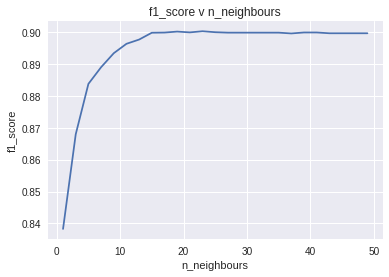

In [51]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [52]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 23


In [53]:
# calculating model accuracy , f1_score on test data
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='brute')
knn.fit(tfidf_sent_vectors_train  , y_train)
pred = knn.predict(tfidf_sent_vectors_test )
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)

f1-score: 0.9088427947598253
accuracy: 0.833


In [54]:
# finding optimal K using 'kd-tree' algorithm 
f1 = list()
n = np.arange(1,50,2)
for i in n:
    knn = KNeighborsClassifier(n_neighbors = i , algorithm='kd_tree')
    knn.fit(tfidf_sent_vectors_train , y_train)
    pred = knn.predict(tfidf_sent_vectors_cv)
    score = f1_score(y_cv, pred) 
    f1.append(score)
    

print (f1)  

[0.8383017163504969, 0.8679354094579007, 0.8837340876944838, 0.888951205832866, 0.8933444722918408, 0.8962839711591792, 0.8976203652462644, 0.899751449875725, 0.8998067899530776, 0.9001103752759383, 0.8998620689655172, 0.9002205071664828, 0.8999172870140613, 0.8997797356828194, 0.8997797356828194, 0.8997797356828194, 0.8997797356828194, 0.8997797356828194, 0.8995320671621251, 0.8998348926802422, 0.8998348926802422, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705, 0.8995873452544705]


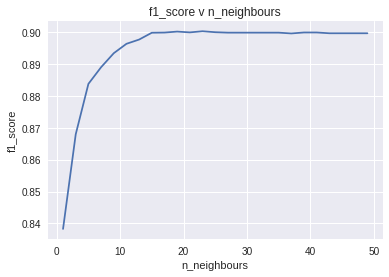

In [55]:
n_neighbour = np.arange(1,50,2)
#plotting f1_score and neighbours 
plt.plot(n_neighbour, f1,'-')
plt.xlabel('n_neighbours')
plt.ylabel('f1_score')
plt.title('f1_score v n_neighbours')
plt.grid(True)
plt.show()

In [56]:
import numpy as np
ind = np.argmax(f1)
print ('number of neighbours :',n[ind] )

number of neighbours : 23


In [57]:
# calculating model accuracy , f1_score on test data
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = n[ind] , algorithm='kd_tree')
knn.fit(tfidf_sent_vectors_train  , y_train)
pred = knn.predict(tfidf_sent_vectors_test )
score = f1_score(y_test, pred) 
print ("f1-score:", score)
acc= accuracy_score(y_test, pred)
print ('accuracy:',acc)

f1-score: 0.9088427947598253
accuracy: 0.833


In [59]:
! pip install PTable
from prettytable import PrettyTable

  Running setup.py bdist_wheel for PTable ... - done
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [60]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Algorithm", "Hyper-parameter", "f1_score"]

x.add_row(["BOW","brute", 9, 0.909])
x.add_row(["BOW","kd-tree", 15, 0.910])
x.add_row(["tfidf","brute", 7, 0.915])
x.add_row(["tfidf","kd-tree", 7, 0.914])
x.add_row(["avg-w2v","brute", 25, 0.909])
x.add_row(["avg-w2v","kd-tree", 25, 0.909])
x.add_row(["tfidf-w2v","brute", 23, 0.908])
x.add_row(["tfidf-w2v","kd-tree", 23, 0.908])

print(x)

+------------+-----------+-----------------+----------+
| Vectorizer | Algorithm | Hyper-parameter | f1_score |
+------------+-----------+-----------------+----------+
|    BOW     |   brute   |        9        |  0.909   |
|    BOW     |  kd-tree  |        15       |   0.91   |
|   tfidf    |   brute   |        7        |  0.915   |
|   tfidf    |  kd-tree  |        7        |  0.914   |
|  avg-w2v   |   brute   |        25       |  0.909   |
|  avg-w2v   |  kd-tree  |        25       |  0.909   |
| tfidf-w2v  |   brute   |        23       |  0.908   |
| tfidf-w2v  |  kd-tree  |        23       |  0.908   |
+------------+-----------+-----------------+----------+
